In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    f1_score,
    precision_score,
    recall_score
)
from Preprocessing import *

kernel_matrix_train = np.load("kernel_matrix_train.npy")
kernel_matrix_test = np.load("kernel_matrix_test.npy")

# Data paths
TRAIN_FILE = '../Data/kernel_estimation_train.csv'
TEST_FILE = '../Data/kernel_estimation_test.csv'
VAL_FILE = '../Data/kernel_estimation_val.csv'

# Load training data
df_train = pd.read_csv(TRAIN_FILE)
# Load test data
df_test = pd.read_csv(TEST_FILE)
# Load validation data
df_val = pd.read_csv(VAL_FILE)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(validation_data, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

df_label_train = pd.read_csv(TRAIN_FILE)["ef_class"]
df_train = df_train[df_label_train.isin([2,3])]
df_label_test = pd.read_csv(TEST_FILE)["ef_class"]
df_test = df_test[df_label_test.isin([2,3])]
df_label_val = pd.read_csv(VAL_FILE)["ef_class"]
df_val = df_val[df_label_val.isin([2,3])]

df_train = df_train[df_train.columns[:-2]]
df_test = df_test[df_test.columns[:-2]]
df_val = df_val[df_val.columns[:-2]]
print(df_label_test.head())

df_label_train = (df_label_train.to_numpy() == 3).astype(int)
df_label_test = (df_label_test == 3).astype(int)
df_label_val = (df_label_val == 3).astype(int)

print(df_label_train)

X_train, y_train, X_test, y_test, X_smote_test, y_smote_test = Preprocess(df_train, df_test, df_val, balance = 'smote', classes = 'binary')

print(y_test[:])
print(y_train[:])

train_data = ClassificationDataset(X_train, y_train)
validation_data = ClassificationDataset(X_val, y_val)
test_data = ClassificationDataset(X_test, y_test)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


ModuleNotFoundError: No module named 'torchvision'

In [43]:
#SVC Classifier
svc = SVC(kernel='precomputed', probability=True)
svc.fit(kernel_matrix_train, df_label_train)
y_test = df_label_test
# Predict and probabilities
y_pred = svc.predict(kernel_matrix_test)
y_prob = svc.predict_proba(kernel_matrix_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

print("Accuracy:", acc)
print("AUC:", auc)
print("Confusion Matrix:\n", cm)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7619047619047619
AUC: 0.6625
Confusion Matrix:
 [[16  0]
 [ 5  0]]
F1: 0.0
Precision: 0.0
Recall: 0.0


/work/submit/norwa667/workspaces/myenv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


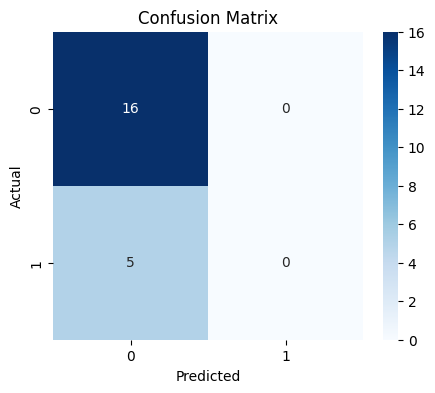

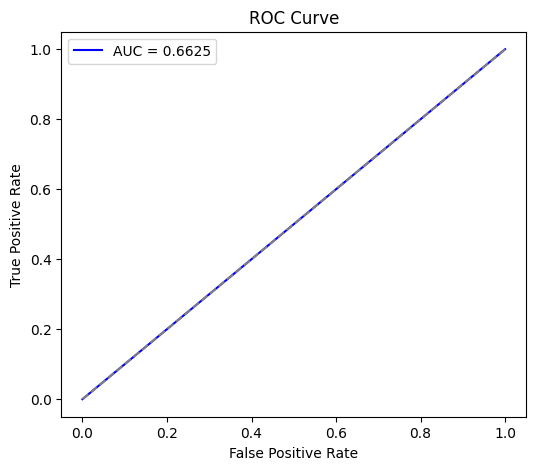

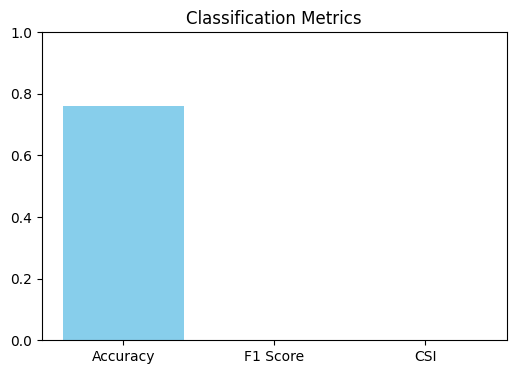

In [47]:
import seaborn as sns

# Critical Success Index (CSI)
tp = cm[1,1]
fn = cm[1,0]
fp = cm[0,1]
csi = tp / (tp + fn + fp)

# --- Plot Confusion Matrix ---
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- Plot ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# --- Plot Metrics Bar Chart ---
metrics = {'Accuracy': acc, 'F1 Score': f1, 'CSI': csi}
plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'orange', 'green'])
plt.ylim(0,1)
plt.title('Classification Metrics')
plt.show()